In [387]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 15
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 20

PATHS = [
    # Clamped units
    './models/model-hierarchicalmode-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1-0.5beta-20210220-000132',
    # Absolute values
    './models/model-hierarchicalmode-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1-0.5beta-20210220-210621'
]
PATH = PATHS[0]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = PATH + '.pt'
)

# Load dataset
train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
print("Training dataset length:", len(train_dataset))

Using cpu
Training dataset length: 80


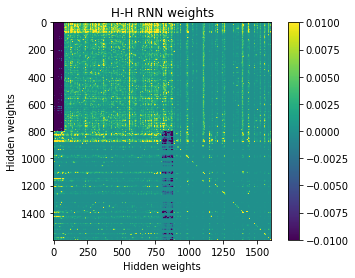

In [287]:
# Plot weight matrices
plt.imshow(model.rnn.weight_hh_l0.detach().numpy(), vmin=-0.01, vmax=0.01)
plt.xlabel('Hidden weights')
plt.ylabel('Hidden weights')
plt.title("H-H RNN weights")
plt.colorbar()
plt.show()

In [ ]:
# Plot loss history
with open(PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [426]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 1000

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 100 == 99:
        print('Trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())

averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), averaged_stimuli_group1[1]
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), averaged_stimuli_group2[1]
        
print('Finished averaging stimuli')

Trial 100
Trial 200
Trial 300
Trial 400
Trial 500
Trial 600
Trial 700
Trial 800
Trial 900
Trial 1000
Finished averaging stimuli


Text(-0.025, 0.5, 'Postsynaptic unit')

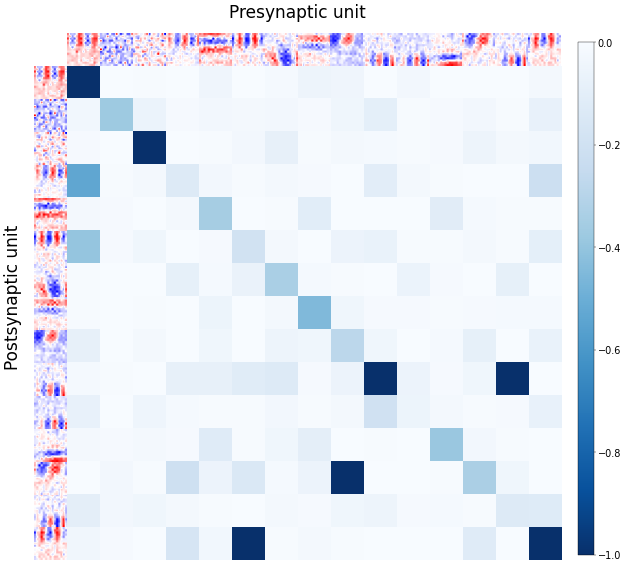

In [481]:
# Visualise connections between recurrent units

starting_idx = 0
n_units = 15
units_slice = slice(starting_idx, starting_idx+n_units)

hh_indices = averaged_stimuli_group1[1][units_slice]
hh_weights = model.rnn.weight_hh_l0.detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for row in range(n_units):
    for col in range(n_units):
        hh_weights_subset[row, col] = hh_weights[hh_indices[row], hh_indices[col]]

sta_RFs = max_abs_normalize(averaged_stimuli_group1[0][units_slice])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='Blues_r', vmin=-1)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(sta_RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.5, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)


In [ ]:
# Virtual physiology
def plot_grating_animation (gratings):
    fig = plt.figure(dpi=40)
    init_data = gratings.detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=25)
    def animate(i):
        im_data = gratings.detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=WARMUP+T_STEPS, interval=100
    )
    HTML(anim.to_html5_video())

def generate_gratings (frequency, transpose):
    gratings = []
    count = 0
    for i in range(WARMUP+T_STEPS+1):
        phase = np.pi*count

        x_range = np.linspace(0, 2*np.pi, num=FRAME_SIZE)
        y = np.sin(x_range*frequency + phase)

        grating = np.repeat(y, 15, axis=0)
        if transpose:
            grating = grating.reshape((FRAME_SIZE, FRAME_SIZE)).transpose().reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
        count -= 0.5
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

unit_n = 20
sta = normalize(averaged_stimuli_group1[0])[unit_n]
unit_n = averaged_stimuli_group1[1][unit_n]

fig = plt.figure(dpi=40)
plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
plt.title('Normalized SA', size=25)

fig, axs = plt.subplots(nrows=5, ncols= 5, dpi=100, sharey=True, sharex=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

responses = []
i = 1
for ax in axs.flat:
    activity = []
    _, hidden_state = model(generate_gratings(i, False))
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        unit = hidden_state[0, t_step, unit_n]
        activity.append(unit.detach().numpy())
    ax.plot(activity)
    ax.set_title("f = {}".format(i))
    
    responses.append(max(activity[4:-4]))
    
    i += 0.5
    
fig = plt.figure()
plt.plot(responses)

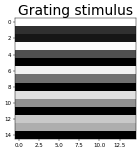

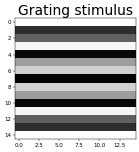

In [599]:
plot_grating_animation(generate_gratings(4.5, False))
plot_grating_animation(generate_gratings(9, False))

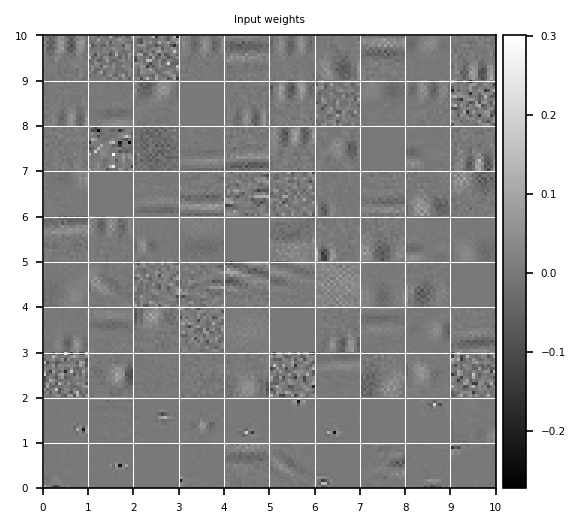

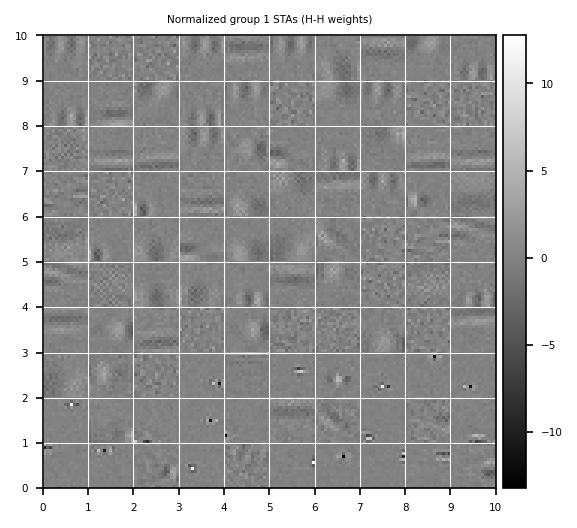

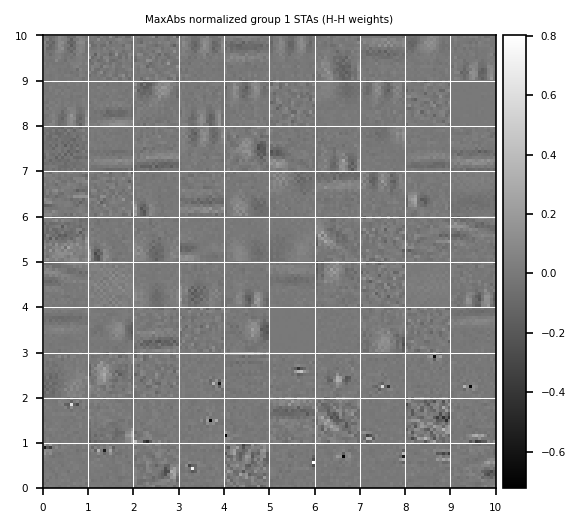

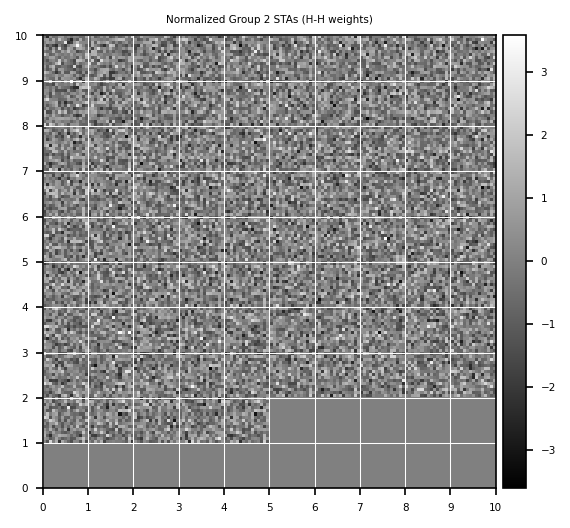

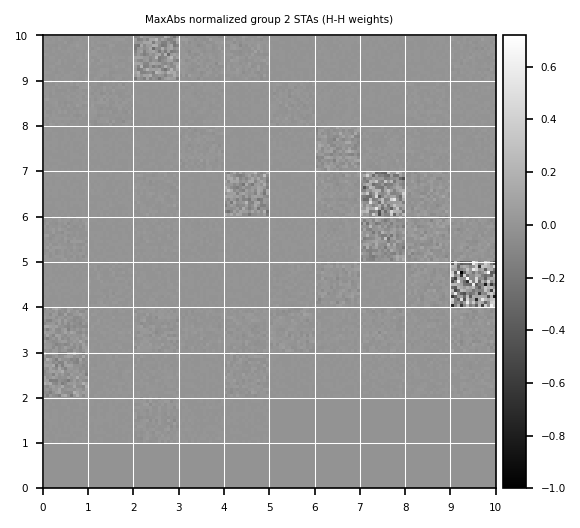

In [289]:
# Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=150)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (10, 10, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")

In [ ]:
# Visualise network predictions
x, y = train_dataset[8]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred, _ = model(torch.unsqueeze(x, 0))
pred = torch.squeeze(pred, 0)

steps = 10

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_y = y[WARMUP+i].view(FRAME_SIZE, FRAME_SIZE).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Target', size=7)
plt.show()

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_pred = pred[i, :FRAME_SIZE**2].view(FRAME_SIZE, FRAME_SIZE).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Predicted', size=7)
plt.show()